In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

sys.path.append('../src/')
import sergio_kd.sergio as sergio
import networkx as nx

from sergio_kd.graph import DirectedGraphGenerator

from sergio_kd.input_gen import Sergio_KD, plot_dag
import scp_infer as scpi
%matplotlib inline

/home/pi226/.conda/envs/jax-pytorch/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
Detecting 4 CUDA device(s).


## Run SERGIO-Knockdown gene expression Simulator

Content:
 - specify simulation parameters
 - Run Simulation of raw gene expression with knockdowns
 - apply different technical noise simulations to resulting gene expression


### 1. Simulation of Gene Expression

##### a. Set the Simulation Parameters

Define the simulation parameters, GRN and initial conditions.

In [2]:
# Simulation Parameters
num_genes = 10     # number of genes
number_sc = 200    #200    # total number of cells per cell type, default 300
noise_amp = 0.6    # noise parameters, default 1
decays = 0.8       # dnoise_runecay rate, default 0.8

# GRN parameters
edge_density = 0.5
hill_coeff = 2

# Expression / Perturbation parameters
MR_low = 0.3
MR_high = 1.3
Hill_K = 1.8
KD_percent = 0.0

# GRN information files
data_dir = './data/techn_noise_run_17_test/'

# Noise parameters
apply_noise = False
apply_outliers = False
apply_lib_size = False
apply_dropout = False
apply_umi_conversion = False
rate_per_gene = False

dropout_k = 8
dropout_percentile = 70

In [3]:
noise_str = ""
if apply_outliers:
    noise_str += "o"
if apply_lib_size:
    noise_str += "l"
if apply_dropout:
    noise_str += "d"
if apply_umi_conversion:
    noise_str += "c"

if not apply_noise:
    noise_str = "n"

out_filename = 'q_'+str(noise_amp)+'_d_'+str(num_genes)+'_edgeden_'+str(edge_density)+'_kd_'+str(KD_percent)+'_nsamp_'+str(number_sc)+'_noise_'+noise_str+'_'+str(0)
print(out_filename)

q_0.6_d_10_edgeden_0.5_kd_0.0_nsamp_200_noise_n_0


##### b. Specify the underlying GRN / Graph

load graph from file.

n_edges:  5.0
graph is acyclic:  True


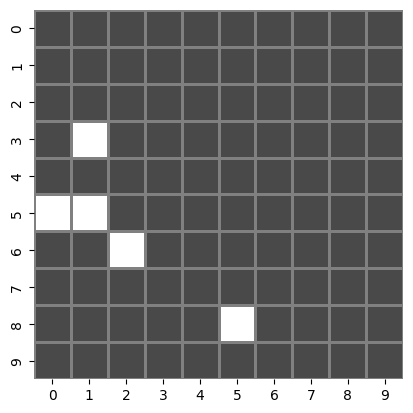

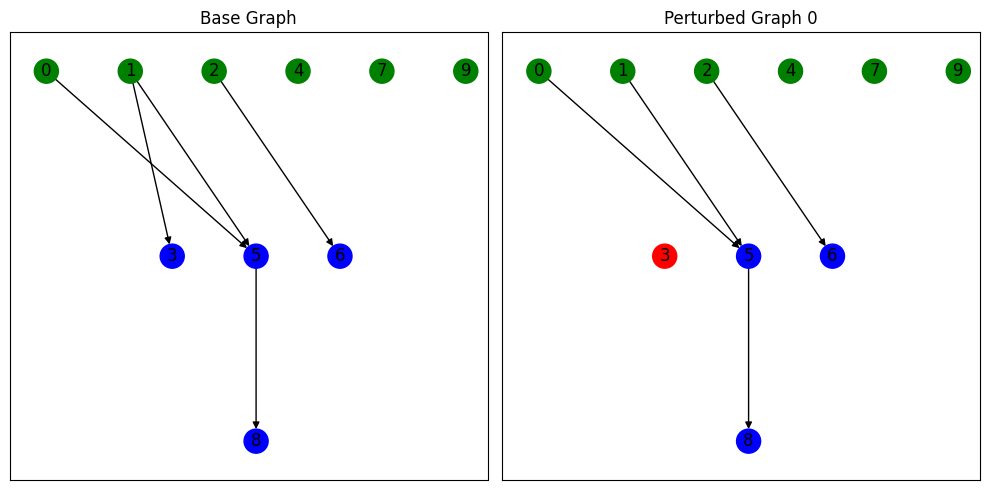

graph is acyclic:  True


In [4]:
load_graph = False
load_filename = 'q_'+str(noise_amp)+'_d_'+str(num_genes)+'_edgeden_'+str(edge_density)+'_kd_'+str(KD_percent)+'_nsamp_'+str(number_sc)+'_noise_'+'n'+'_'+str(4)
if load_graph:
    file = os.path.join(data_dir, 'output_files', 'graph_'+load_filename+'.csv')
    adj_mat = np.loadtxt(file, delimiter=',')
else:
    graph_gen = DirectedGraphGenerator(nodes=num_genes,expected_density=edge_density,enforce_dag=True)
    graph_gen()
    adj_mat = graph_gen.adjacency_matrix.T
    # save graph adjacency matrix to file
    #np.savetxt(file, adj_mat, delimiter=',', fmt='%d')
    print('n_edges: ', np.sum(adj_mat))
    print("graph is acyclic: ",nx.is_directed_acyclic_graph(graph_gen.g))
network = nx.from_numpy_array(adj_mat.T, create_using=nx.DiGraph)
sns.heatmap(adj_mat, cbar=False,linewidths = 2, linecolor = 'gray', cmap='gray',vmin=-0.4,vmax=1, square=True)
plt.savefig('./plots/techn_noise_run_17_2_adjmat.svg')
plot_dag(network, n_plots=1)
print("graph is acyclic: ",nx.is_directed_acyclic_graph(network))


### 2. Run Simulation

Initialize the simulator with the given parameters and GRN Graph.

In [5]:
kd_simulator = Sergio_KD(
    data_dir=data_dir,
    num_genes=num_genes,
    number_sc=number_sc,
    noise_amp=noise_amp,
    decays=decays,
    edge_den=edge_density,
    hill_coeff=hill_coeff,
    MR_low=MR_low,
    MR_high=MR_high,
    Hill_K=Hill_K,
    KD_percent=KD_percent,
    apply_noise=apply_noise,
    apply_outliers=apply_outliers,
    apply_lib_size=apply_lib_size,
    apply_dropout=apply_dropout,
    dropout_k = dropout_k,
    dropout_percentile = dropout_percentile,
    rate_per_gene = rate_per_gene,
    apply_umi_conversion=apply_umi_conversion,
    out_filename=out_filename,
)

Create GRN.csv and MR.csv files for each simulation scenario that describe the GRN structure to SERGIO. 

In [6]:
kd_simulator.adj_mat = adj_mat
print(kd_simulator.adj_mat)
kd_simulator.gen_inputfiles()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
target genes: [3, 5, 6, 8]
master regulators: [0, 1, 2, 4, 7, 9]


Run the actual simulation.

In [7]:
kd_simulator.run_simulation()

removing previous files in:  ./data/techn_noise_run_17_test/expression_files
Running initial simulation with base GRN to compute mean expression values.
label:  non-targeting


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Computed Half-Response Values:  [1.29355115 1.08666584 1.3184543  1.06109802 1.53713286 2.00744619 1.06923331 0.42219281 1.00721628 1.02803958]
removing previous files in:  ./data/techn_noise_run_17_test/expression_files
Re-running unperturbed simulation with updated half-response-values to compute mean expression values.
label:  non-targeting


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


mean epression values:  [1.14218667 1.11013051 1.20770555 1.18015437 1.33725628 1.02881205 1.14566998 0.49834175 0.93764722 1.16903745]
Creating perturbed GRN and MR files.
removing previous files in:  ./data/techn_noise_run_17_test/perturb_GRN_files
perturbed gene: 0
replacing row 0
perturbed gene: 1
replacing row 1
perturbed gene: 2
replacing row 2
perturbed gene: 3
perturbed gene: 4
replacing row 3
perturbed gene: 5
perturbed gene: 6
perturbed gene: 7
replacing row 4
perturbed gene: 8
perturbed gene: 9
replacing row 5
removing previous files in:  ./data/techn_noise_run_17_test/expression_files
Running full simulation with unperturbed and perturbed GRN.
label:  non-targeting


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


label:  gene_0_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


label:  gene_1_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


label:  gene_2_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


label:  gene_3_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


label:  gene_4_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


label:  gene_5_perturbed


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


label:  gene_6_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


label:  gene_7_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


label:  gene_8_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


label:  gene_9_perturbed


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Combine resulting expression values from each simulation into one array and read out perturbation annotation.

Save raw results as AnnData file to use like an experimental dataset with scp-infer.

In [8]:
kd_simulator.combine_expr(normalize=False, shifted_log=apply_umi_conversion)
adata = sc.read(os.path.join(data_dir, 'output_files', 'sim_output_'+out_filename+'.h5ad'))

expression_files:  ['gene_0_perturbed_replicate0_expr.npy', 'gene_0_perturbed_replicate1_expr.npy', 'gene_0_perturbed_replicate2_expr.npy']
perturbations:  ['gene-0', 'gene-0', 'gene-0']
complete_counts:  (70, 10, 200)
complete_perturbations:  (14000,)
Non-targeting: 4000
Multiplet: 0
Control: 0
Nan: 0
Normal pert.: 10000
Filtered 0 un-identifiable perturbations:  10000 filtered perturbations

 Created AnnData object: 
AnnData object with n_obs × n_vars = 14000 × 10
    obs: 'perturbation', 'non-targeting', 'multiplet', 'control', 'nan', 'gene_perturbation_mask'
    var: 'gene_perturbed'
gene names:  ['gene-0', 'gene-1', 'gene-2', 'gene-3', 'gene-4', 'gene-5', 'gene-6', 'gene-7', 'gene-8', 'gene-9']
perturbation
non-targeting    4000
gene-0           1000
gene-1           1000
gene-2           1000
gene-3           1000
gene-4           1000
gene-5           1000
gene-6           1000
gene-7           1000
gene-8           1000
gene-9           1000
Name: count, dtype: int64
Writing An

/home/pi226/.conda/envs/jax-pytorch/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/home/pi226/documents/inference-pkg/tutorials/../src/scp_infer/adata/filter_adata.py:217: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.


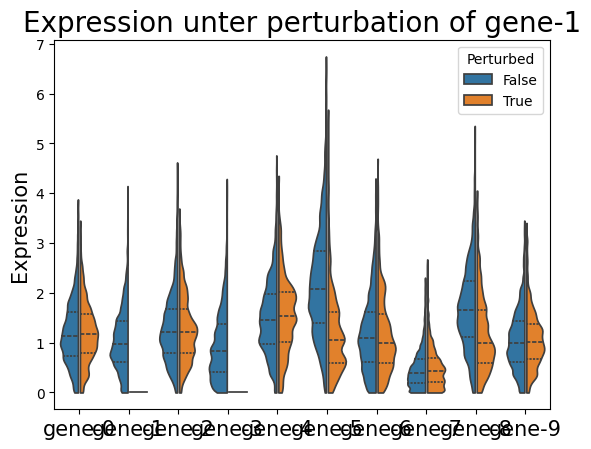

In [9]:
#scpi.adata.plot_target_downreg(adata[::2], non_targeting_only=True, n_genes=15)
scpi.adata.plot_perturbation_expression(adata[::2], non_targeting_only=True, n_genes=15,pert_gene = 'gene-1')

### 3. Apply technical noise

Apply each noise transformation to the just created dataset and save respective adata (+limit) files.

In [14]:
noise_combinations = ['n','d', 'c', 'dc']
adata_list = []
for noise_str in noise_combinations:
    out_filename = 'q_'+str(noise_amp)+'_d_'+str(num_genes)+'_edgeden_'+str(edge_density)+'_kd_'+str(KD_percent)+'_nsamp_'+str(number_sc)+'_noise_'+noise_str+'_'+str(0)
    print(out_filename)
    
    apply_noise = True
    apply_o = noise_str.find('o') > -1
    apply_l = noise_str.find('l') > -1
    apply_d = noise_str.find('d') > -1
    apply_c = noise_str.find('c') > -1

    kd_simulator = Sergio_KD(
        data_dir=data_dir,
        num_genes=num_genes,
        number_sc=number_sc,
        noise_amp=noise_amp,
        decays=decays,
        edge_den=edge_density,
        hill_coeff=hill_coeff,
        MR_low=MR_low,
        MR_high=MR_high,
        KD_percent=KD_percent,
        apply_noise=apply_noise,
        apply_outliers=apply_o,
        apply_lib_size=apply_l,
        apply_dropout=apply_d,
        dropout_k = dropout_k,
        dropout_percentile = dropout_percentile,
        apply_umi_conversion=apply_c,
        out_filename=out_filename
    )

    kd_simulator.adj_mat = adj_mat
    print(kd_simulator.adj_mat)

    kd_simulator.combine_expr(normalize=apply_l, shifted_log=apply_c)
    

q_0.6_d_10_edgeden_0.5_kd_0.0_nsamp_200_noise_n_0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
expression_files:  ['gene_0_perturbed_replicate0_expr.npy', 'gene_0_perturbed_replicate1_expr.npy', 'gene_0_perturbed_replicate2_expr.npy']
perturbations:  ['gene-0', 'gene-0', 'gene-0']
complete_counts:  (70, 10, 200)
complete_perturbations:  (14000,)
Non-targeting: 4000
Multiplet: 0
Control: 0
Nan: 0
Normal pert.: 10000
Filtered 0 un-identifiable perturbations:  10000 filtered perturbations

 Created AnnData object: 
AnnData object with n_obs × n_vars = 14000 × 10
    obs: 'perturbation', 'non-targeting', 'multiplet', 'control', 'nan', 'gene_perturbation_mask'
    var: 'gene_perturbed'
gene names:  ['gene-0', 

Saving graph to:  ./data/techn_noise_run_17_test/output_files/graph_q_0.6_d_10_edgeden_0.5_kd_0.0_nsamp_200_noise_n_0.csv
q_0.6_d_10_edgeden_0.5_kd_0.0_nsamp_200_noise_d_0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
expression_files:  ['gene_0_perturbed_replicate0_expr.npy', 'gene_0_perturbed_replicate1_expr.npy', 'gene_0_perturbed_replicate2_expr.npy']
perturbations:  ['gene-0', 'gene-0', 'gene-0']
complete_counts:  (70, 10, 200)
complete_perturbations:  (14000,)
Non-targeting: 4000
Multiplet: 0
Control: 0
Nan: 0
Normal pert.: 10000
Filtered 0 un-identifiable perturbations:  10000 filtered perturbations

 Created AnnData object: 
AnnData object with n_obs × n_vars = 14000 × 10
    obs: 'perturbation', '

/home/pi226/.conda/envs/jax-pytorch/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/home/pi226/documents/inference-pkg/tutorials/../src/scp_infer/adata/filter_adata.py:217: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
/home/pi226/.conda/envs/jax-pytorch/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/home/pi226/documents/inference-pkg/tutorials/../src/scp_infer/adata/filter_adata.py:217: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
/home/pi226/.conda/envs/jax-pytorch/lib/python

Non-targeting: 4000
Multiplet: 0
Control: 0
Nan: 0
Normal pert.: 10000
Filtered 0 un-identifiable perturbations:  10000 filtered perturbations

 Created AnnData object: 
AnnData object with n_obs × n_vars = 14000 × 10
    obs: 'perturbation', 'non-targeting', 'multiplet', 'control', 'nan', 'gene_perturbation_mask'
    var: 'gene_perturbed'
    uns: 'log1p'
gene names:  ['gene-0', 'gene-1', 'gene-2', 'gene-3', 'gene-4', 'gene-5', 'gene-6', 'gene-7', 'gene-8', 'gene-9']
perturbation
non-targeting    4000
gene-0           1000
gene-1           1000
gene-2           1000
gene-3           1000
gene-4           1000
gene-5           1000
gene-6           1000
gene-7           1000
gene-8           1000
gene-9           1000
Name: count, dtype: int64
Writing AnnData object to:  ./data/techn_noise_run_17_test/output_files/sim_output_q_0.6_d_10_edgeden_0.5_kd_0.0_nsamp_200_noise_dc_0.h5ad
Only considering the two last: ['.0_nsamp_200_noise_dc_0', '.h5ad'].
Only considering the two last: ['.0_ns

/home/pi226/.conda/envs/jax-pytorch/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/home/pi226/documents/inference-pkg/tutorials/../src/scp_infer/adata/filter_adata.py:217: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.


In [127]:
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata) #logarithmize the data

#scpi.adata.plot_target_downreg(adata, non_targeting_only=True, n_genes=15)

Number of genes in raw simulated data: 10
raw simulated - mean sparsity:  0.10940714285714286
Number of genes in counts data: 10
counts - mean sparsity:  0.4420857142857143
Number of genes in counts + dropout data: 10
counts + dropout - mean sparsity:  0.7390857142857143


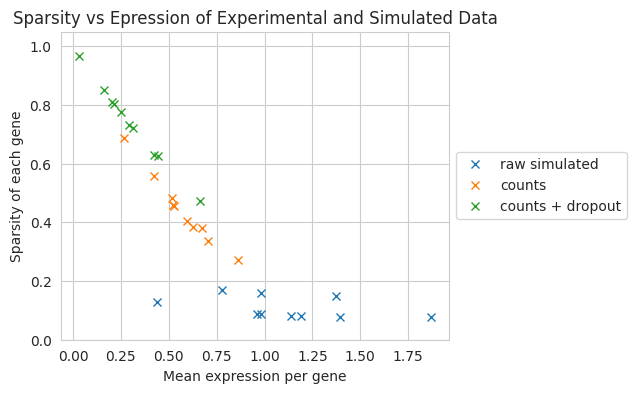

In [12]:

sns.set_style("whitegrid")

fig,ax = plt.subplots(figsize=(5,4))
noise_labels = ['raw simulated','counts','counts + dropout']
#TGFB-PerturbSeq
for adata_obj, label, marker in zip([adata_list[0],adata_list[2],adata_list[3]],noise_labels,['x','x','x','x']):
    n_genes = adata_obj.X.shape[1]
    print(f"Number of genes in {label} data: {n_genes}")
    mean_expr_per_gene = adata_obj.X.mean(axis=0)
    zero_count_genes = np.sum(adata_obj.X == 0, axis=0)/adata_obj.X.shape[0]
    # get array into list shape
    if label == 'Experimental':
        print("Experimental data")
        
        mean_expr_per_gene = np.squeeze(np.asarray(mean_expr_per_gene))
        zero_count_genes = np.squeeze(np.asarray(zero_count_genes))

        mean_expr_per_gene = np.reshape(mean_expr_per_gene,np.size(mean_expr_per_gene))
        print(np.shape(mean_expr_per_gene), np.shape(zero_count_genes))
        print(mean_expr_per_gene)
    ax.plot(mean_expr_per_gene, zero_count_genes, marker, label=label)
    print(label,'- mean sparsity: ',np.mean(zero_count_genes))

plt.ylim((0,1.05))
ax.set_xlabel("Mean expression per gene")
ax.set_ylabel("Sparsity of each gene")
plt.title('Sparsity vs Epression of Experimental and Simulated Data')
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('./plots/sparsity_mean_other_v9.pdf',bbox_inches='tight')

plt.show()

Split into Validation and train.

### Full Loop
Run this data-generation for a few times to produce a set of comparable datasets.

In [ ]:
noise_combinations = ['n', 'd', 'c', 'dc']
nsamp_vals = [5, 25, 50, 100, 200, 800]
q_vals = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
kd_percent_vals = [1.0, 0.7, 0.4, 0.2, 0.1, 0.0]
n_gene_arr = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
#full loop
for iteration in range(15):       
    # 1. generate base Dataset without technical noise transformation
    noise_str = 'n'
    out_filename = 'q_'+str(noise_amp)+'_d_'+str(num_genes)+'_edgeden_'+str(edge_density)+'_kd_'+str(KD_percent)+'_nsamp_'+str(number_sc)+'_noise_'+noise_str+'_'+str(iteration)
    print(out_filename)
    load_graph = False
    if load_graph:
        file = os.path.join(data_dir, 'raw_GRN_files', 'graph'+out_filename+'.csv')
        adj_mat = np.loadtxt(file, delimiter=',')
        network = nx.from_numpy_array(adj_mat.T, create_using=nx.DiGraph)
    else:
        graph_gen = DirectedGraphGenerator(nodes=num_genes,expected_density=edge_density,enforce_dag=True)
        graph_gen()
        adj_mat = graph_gen.adjacency_matrix.T
        # save graph adjacency matrix to file
        #np.savetxt(file, adj_mat, delimiter=',', fmt='%d')

    network = nx.from_numpy_array(adj_mat.T, create_using=nx.DiGraph)
    sns.heatmap(adj_mat, cbar=False,linewidths = 2, linecolor = 'gray', cmap='gray',vmin=-0.4,vmax=1, square=True)
    plot_dag(network, n_plots=1)
    print("graph is acyclic: ",nx.is_directed_acyclic_graph(graph_gen.g))

    apply_noise = not noise_str.find('n') > -1
    print('applt_noise: ',apply_noise)
    apply_o = noise_str.find('o') > -1
    apply_l = noise_str.find('l') > -1
    apply_d = noise_str.find('d') > -1
    apply_c = noise_str.find('c') > -1
    
    kd_simulator = Sergio_KD(
        data_dir=data_dir,
        num_genes=num_genes,
        number_sc=number_sc,
        noise_amp=noise_amp,
        decays=decays,
        edge_den=edge_density,
        hill_coeff=hill_coeff,
        MR_low=MR_low,
        MR_high=MR_high,
        Hill_K=Hill_K,
        KD_percent=KD_percent,
        apply_noise=apply_noise,
        apply_outliers=apply_o,
        apply_lib_size=apply_l,
        apply_dropout=apply_d,
        dropout_k = dropout_k,
        dropout_percentile = dropout_percentile,
        rate_per_gene = rate_per_gene,
        apply_umi_conversion=apply_c,
        out_filename=out_filename,
    )

    kd_simulator.adj_mat = adj_mat
    print(kd_simulator.adj_mat)
    kd_simulator.gen_inputfiles()

    kd_simulator.run_simulation()

    kd_simulator.combine_expr(normalize=apply_l, shifted_log=apply_c)

    if True:
        print('plotting: ',out_filename)
        adata = sc.read(os.path.join(data_dir, 'output_files', 'sim_output_'+out_filename+'.h5ad'))
        scpi.adata.plot_perturbation_expression(adata[::4], non_targeting_only=True, n_genes=15,pert_gene = 'gene-4')

    # 2. apply each noise transformation to this current dataset and save as new adata file
    noise_combinations = ['d', 'c', 'dc']
    adata_list = []
    for noise_str in noise_combinations:
        out_filename = 'q_'+str(noise_amp)+'_d_'+str(num_genes)+'_edgeden_'+str(edge_density)+'_kd_'+str(KD_percent)+'_nsamp_'+str(number_sc)+'_noise_'+noise_str+'_'+str(iteration)
        print(out_filename)
        
        apply_noise = not noise_str.find('n') > -1
        print('applt_noise: ',apply_noise)
        apply_o = noise_str.find('o') > -1
        apply_l = noise_str.find('l') > -1
        apply_d = noise_str.find('d') > -1
        apply_c = noise_str.find('c') > -1
    
        kd_simulator = Sergio_KD(
            data_dir=data_dir,
            num_genes=num_genes,
            number_sc=number_sc,
            noise_amp=noise_amp,
            decays=decays,
            edge_den=edge_density,
            hill_coeff=hill_coeff,
            MR_low=MR_low,
            MR_high=MR_high,
            Hill_K=Hill_K,
            KD_percent=KD_percent,
            apply_noise=apply_noise,
            apply_outliers=apply_o,
            apply_lib_size=apply_l,
            apply_dropout=apply_d,
            dropout_k = dropout_k,
            dropout_percentile = dropout_percentile,
            rate_per_gene = rate_per_gene,
            apply_umi_conversion=apply_c,
            out_filename=out_filename,
        )
    
        kd_simulator.adj_mat = adj_mat
        print(kd_simulator.adj_mat)
    
        kd_simulator.combine_expr(normalize=apply_l, shifted_log=apply_c)
        
        adata_noise = sc.read(os.path.join(data_dir, 'output_files', 'sim_output_'+out_filename+'.h5ad'))
        scpi.adata.plot_perturbation_expression(adata_noise[::8], non_targeting_only=True, n_genes=15,pert_gene = 'gene-1')
        adata_list.append(adata_noise)